## Special Topics - Deep Learning Applications

#### Prof. Thomas da Silva Paula

### Faster R-CNN demo

* Pytorch implementation
* Using Faster R-CNN with ResNet 50 backbone, trained on MSCOCO, from torchvision

### Imports

In [1]:
import cv2
import sys
import json
import pprint

import numpy as np
from PIL import Image

import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches


plt.rcParams['figure.figsize'] = [14, 10]

### Useful methods

In [2]:
def read_img(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def load_coco_dict(labels_path):
    with open(labels_path, 'r') as f:
        coco_labels = json.load(f)

    labels_dict = {}
    for info in coco_labels['labels']:
        labels_dict[info['id']] = info['label']
        
    return labels_dict

### Loading pre-trained model

In [3]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

### Loading trained model and COCO labels

In [4]:
labels_dict = load_coco_dict('coco_labels.txt')

In [6]:
labels_dict[90]

'toothbrush'

### Inspecting image

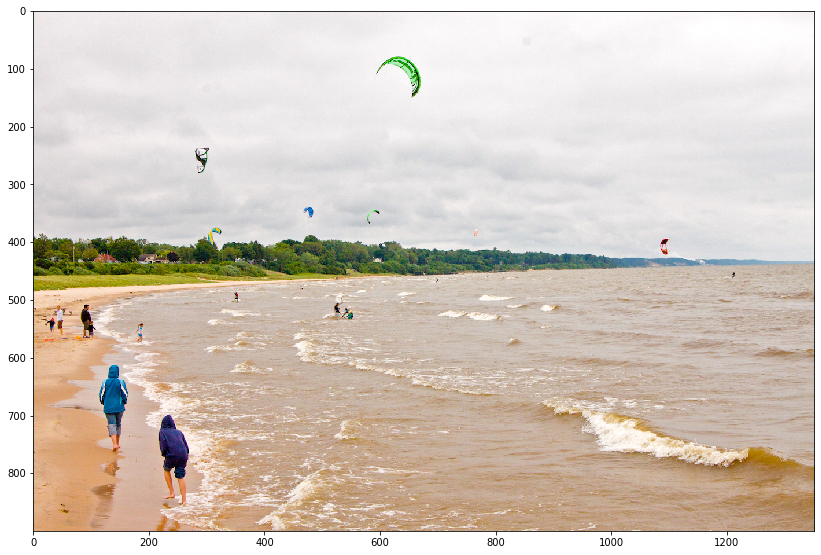

In [7]:
img_path = 'sample_images/beach.jpg'
img = read_img(img_path)
height, width, _ = img.shape
plt.imshow(img)

### Running inference

In [8]:
image = Image.open(img_path)
image_tensor = torchvision.transforms.functional.to_tensor(image)

In [9]:
%%time
output = model([image_tensor])

C:\Users\paulat\Anaconda3\lib\site-packages\torchvision\ops\boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Wall time: 6.32 s


In [12]:
output[0].keys()

dict_keys(['boxes', 'labels', 'scores'])

In [10]:
%%time
pprint.pprint(output)

[{'boxes': tensor([[ 215.7913,  695.3066,  270.7641,  855.9386],
        [ 111.9192,  611.8886,  164.9617,  763.3187],
        [ 594.8027,   77.9598,  670.4895,  151.4964],
        [ 280.2611,  237.1154,  304.1601,  283.0359],
        [ 577.0441,  344.6582,  599.6679,  370.6177],
        [1083.4158,  394.0966, 1100.8839,  424.0855],
        [ 469.0971,  341.0177,  484.9357,  358.9344],
        [  82.2343,  507.9387,  107.0524,  566.4019],
        [ 520.3151,  505.9960,  532.0944,  525.9926],
        [ 534.2235,  514.7147,  553.5134,  534.7492],
        [  36.9923,  512.0062,   54.2548,  558.7717],
        [ 178.0207,  541.1418,  191.9594,  572.6298],
        [ 347.7566,  487.1436,  356.3812,  505.1840],
        [ 301.9599,  374.4996,  326.3046,  408.2704],
        [  24.3386,  529.4717,   39.2459,  555.4383],
        [1206.9381,  452.4211, 1214.2988,  462.8264],
        [ 516.0777,  505.0671,  534.8891,  531.2031],
        [ 461.0206,  473.4846,  467.9352,  482.0889],
        [ 877.127

### Plots detections
Using the `confidence_threshold`. You can notice the difference from Tensorflow in the output boxes, since in this case we do not need to rescale them. We keep the same names as before (left, right, top, bottom) only for reference since we could use them directly

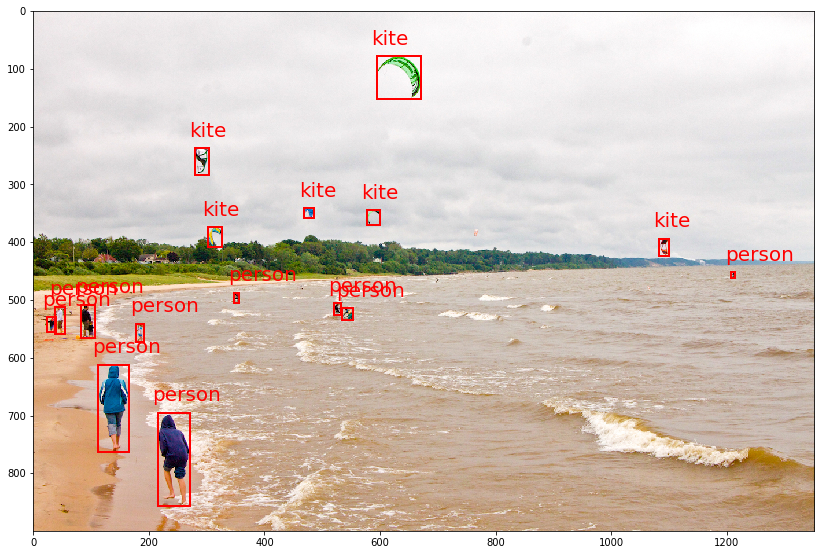

In [13]:
fig, ax = plt.subplots(1)
img = read_img(img_path)
confidence_threshold = .8

for box, cls_id, score in zip(output[0]['boxes'],
                              output[0]['labels'],
                              output[0]['scores']):
    
    xmin, ymin, xmax, ymax = box.data.numpy()
    s = score.data.numpy()
    c = int(cls_id.data.numpy())
    
    if s > confidence_threshold:
        # With TF, here we had to reescale the output
        (left, right, top, bottom) = (xmin, xmax,
                                      ymin, ymax)
        rect = patches.Rectangle((left, top),
                                 right-left,
                                 bottom-top,
                                 linewidth=2, edgecolor='r',
                                 facecolor='none')
        ax.add_patch(rect)
        plt.text(left-10, top-20, labels_dict[c], fontsize=20, color='r')
ax.imshow(img)

### Testing with other images

In [14]:
def predict_and_plot(img_path, confidence_threshold=.8):
    image = Image.open(img_path)
    image_tensor = torchvision.transforms.functional.to_tensor(image)
    
    output = model([image_tensor])
    
    fig, ax = plt.subplots(1)
    img = read_img(img_path)

    for box, cls_id, score in zip(output[0]['boxes'],
                                  output[0]['labels'],
                                  output[0]['scores']):

        xmin, ymin, xmax, ymax = box.data.numpy()
        s = score.data.numpy()
        c = int(cls_id.data.numpy())

        if s > confidence_threshold:
            # With TF, here we had to reescale the output
            (left, right, top, bottom) = (xmin, xmax,
                                          ymin, ymax)
            rect = patches.Rectangle((left, top),
                                     right-left,
                                     bottom-top,
                                     linewidth=2, edgecolor='r',
                                     facecolor='none')
            ax.add_patch(rect)
            plt.text(left-10, top-20, labels_dict[c], fontsize=20, color='r')
    ax.imshow(img)

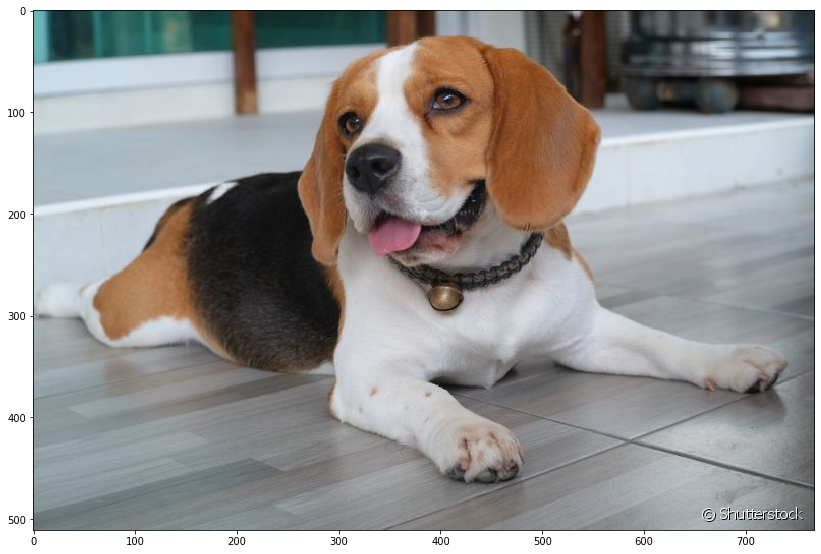

In [15]:
img_path = 'sample_images/dog2.jpg'
img = read_img(img_path)
plt.imshow(img)

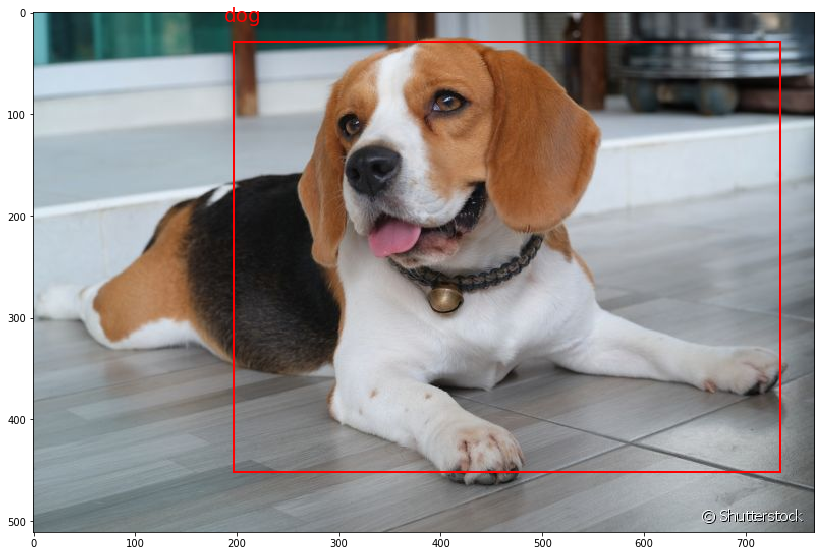

In [16]:
predict_and_plot(img_path, confidence_threshold=.9)

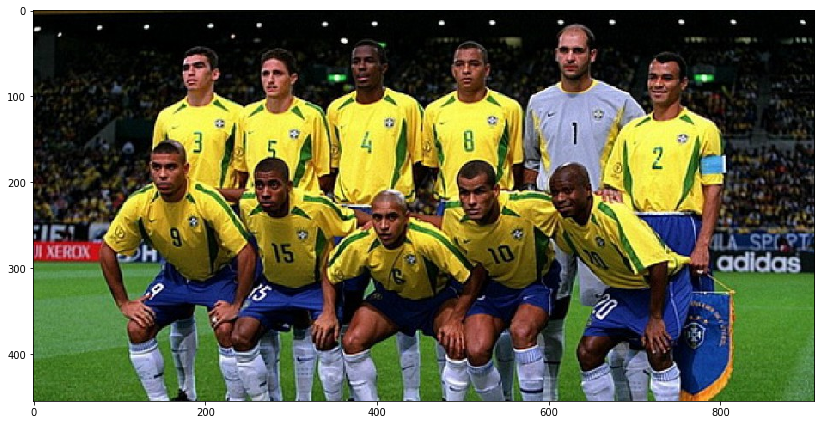

In [17]:
img_path = 'sample_images/soccer.jpg'
img = read_img(img_path)
plt.imshow(img)

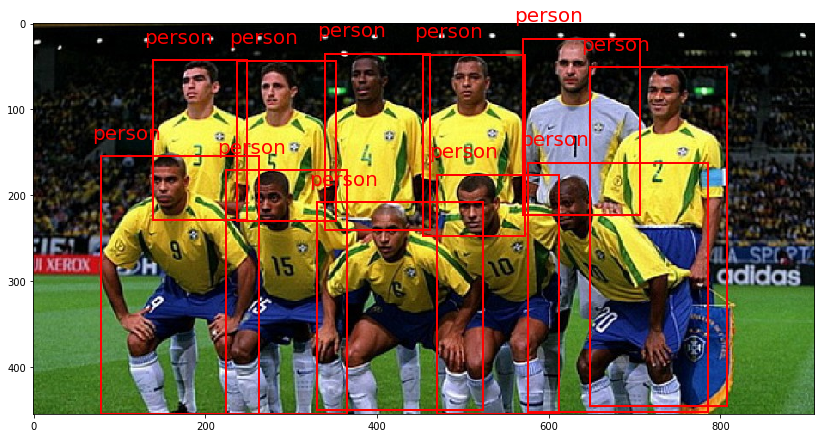

In [18]:
predict_and_plot(img_path, confidence_threshold=.9)

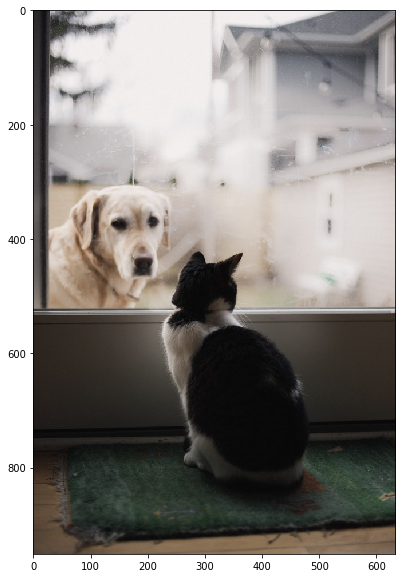

In [19]:
img_path = 'sample_images/cat_dog.jpg'
img = read_img(img_path)
plt.imshow(img)

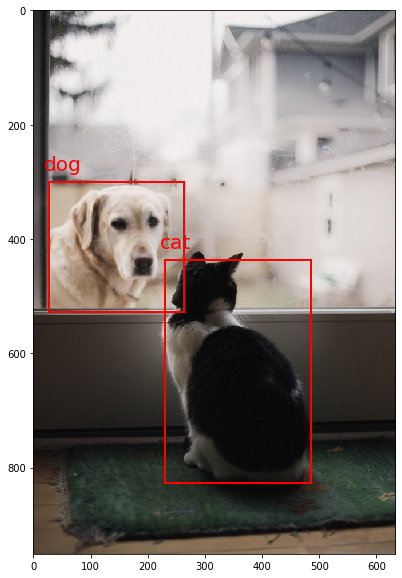

In [20]:
predict_and_plot(img_path, confidence_threshold=.9)